# Video embedding using the Barlow Twins method

This notebook contains code for training a 3D convnet using Barlow Twins. The goal is to embed short video clips of animal behavior in a semantically-meaningful latent space.


In [1]:
import glob 
import joblib
import os
import torch
import tqdm
import numpy as np
import plotly.io as pio
import plotly.express as px
import video_embedding as ve
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from vidio.read import OpenCVReader
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader

## 1. Loading the video and applying augmentations

**Note:**
The current model uses the BatchNorm module of pytorch. This only allows for batch sizes larger than 1. Users should use LayerNorm for batch sizes of 1.

In [2]:
batch_size = 2

image_size = 216
duration = 16 #30
clip_size = 30 #90
num_workers = 1


video_list = ["example_video.mp4"]
print(len(video_list))

augmentator = ve.VideoAugmentator(duration=duration, crop_size=image_size, multiplier=6)
dataset = ve.VidioDataset(video_list, augmentator, clip_size, temporal_downsample=2)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

1


C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [12]:
x_one, x_two = next(iter(dataloader))
x_one = ve.untransform_video(x_one)
x_two = ve.untransform_video(x_two)
ve.play_videos(np.concatenate([x_one[:4],x_two[:4]]), 2, 4)

## 2.Training the model

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, feature_size = ve.get_model("s3d")
learner = ve.BarlowTwins(model, feature_size).to(device).train()
opt = torch.optim.Adam(learner.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

In [4]:
ve.train(
    learner=learner,
    model=model,
    optimizer=opt,
    scheduler=scheduler,
    dataloader=dataloader,
    start_epoch=0,
    epochs=10,
    steps_per_epoch=10,
    checkpoint_dir= 'checkpoint_dir',
    loss_log_path= 'loss_log.txt',
    device=device
)

Epoch 10/10: 100%|████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.01s/batch, loss=1.05e+3]


**Note:** To resume training from a checkpoint, uncomment the following cell.

In [2]:
"""
checkpoint_path = './path/to/checkpoint.pth'
learner, scheduler, opt, model, epoch = ve.load_from_checkpoint(
	checkpoint_path, model, learner, opt, scheduler
)

ve.train(
    learner=learner,
    model=model,
    optimizer=opt,
    scheduler=scheduler,
    dataloader=dataloader,
    start_epoch=epoch+1,
    epochs=10
    steps_per_epoch=10,
    checkpoint_dir='checkpoint_dir',
    loss_log_path='loss_log.txt',
    device=device
)
"""

"\ncheckpoint_path = './path/to/checkpoint.pth'\nlearner, scheduler, opt, model, epoch = ve.load_from_checkpoint(\n\tcheckpoint_path, model, learner, opt, scheduler\n)\n\nve.train(\n    learner=learner,\n    model=model,\n    optimizer=opt,\n    scheduler=scheduler,\n    dataloader=dataloader,\n    start_epoch=epoch+1,\n    epochs=10\n    steps_per_epoch=10,\n    checkpoint_dir='checkpoint_dir',\n    loss_log_path='loss_log.txt',\n    device=device\n)\n"

In [5]:
ve.save_model_info(
    model_dir='path/to/model/model_dir',
    model=model, 
    epoch=10
)

Saved model and parameters to C:\Users\User\Desktop\video-embedding\model_dir\model_checkpoint_10.pth


## 3.Inspecting model 

### 3.1 Training loss curve 

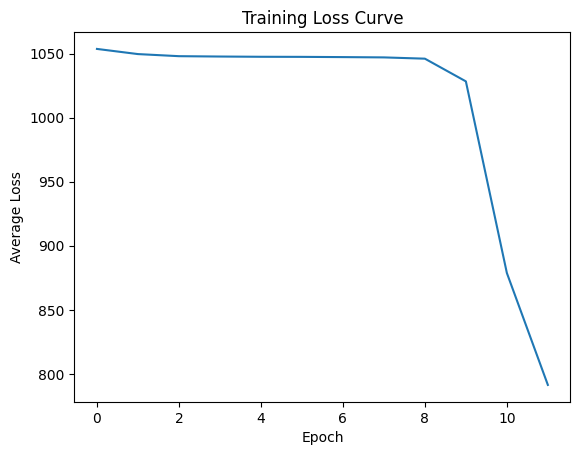

In [16]:
log_loss_path= './path/to/log_loss.txt'
plt.plot(np.loadtxt(log_loss_path, delimiter="\t")[:,1])
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Curve')
plt.grid(False)
plt.show()

### 3.2 2D PCA 

In [7]:
video_paths = ['example_video.mp4']
lengths = [len(OpenCVReader(p)) for p in video_paths]

In [9]:
paths = []
starts = []
embeddings = []

In [11]:
paths = []
starts = []
embeddings = []

for i in tqdm.trange(500):
    ix = np.random.choice(len(video_paths))
    path = video_paths[ix]
    start = np.random.randint(lengths[ix]-60)
    clip = ve.get_clip(path, start, duration=60)[::2]
    clip = ve.center_crop(clip, image_size)
    X = ve.transform_video(clip)[None]
    embedding = model(X.to(device))
    embeddings.append(embedding.detach().cpu().numpy()[0])
    starts.append(start)
    paths.append(path)

embeddings = np.array(embeddings)
joblib.dump((paths, starts, embeddings), 'videoclips.p')


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [16:12<00:00,  1.95s/it]


['videoclips.p']

In [12]:
Xpca = PCA(n_components=20).fit_transform(embeddings)
xy = UMAP(n_components=2, n_neighbors=50).fit_transform(Xpca)

C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


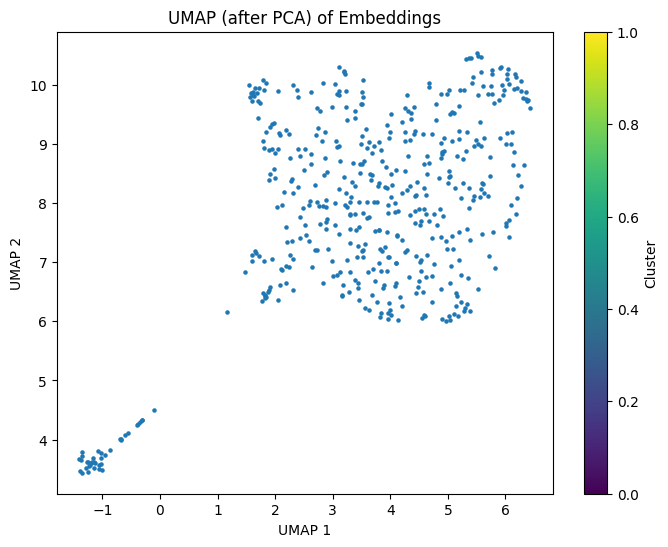

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(xy[:, 0], xy[:, 1], s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP (after PCA) of Embeddings')
plt.colorbar(label='Cluster')
plt.show()


In [14]:
n_clusters = 8
clus = KMeans(n_clusters=n_clusters).fit_predict(Xpca)

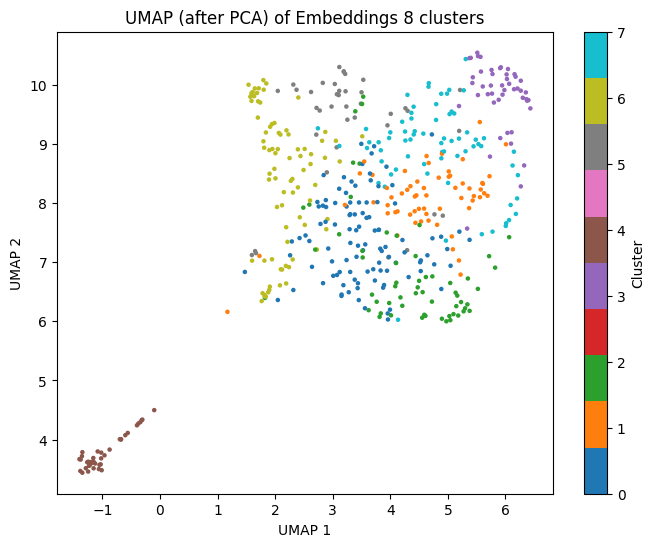

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(xy[:, 0], xy[:, 1], c=clus, cmap='tab10', s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP (after PCA) of Embeddings 8 clusters')
plt.colorbar(label='Cluster')
plt.show()


In [17]:
n_clusters = 16
clus = KMeans(n_clusters=n_clusters).fit_predict(Xpca)

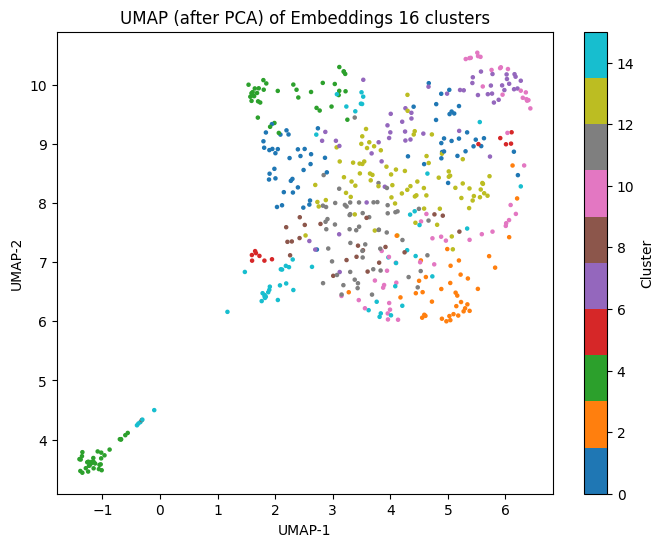

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(xy[:,0], xy[:,1], c=clus, cmap='tab10', s=5)
plt.colorbar(label='Cluster')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.title('UMAP (after PCA) of Embeddings 16 clusters')
plt.show()

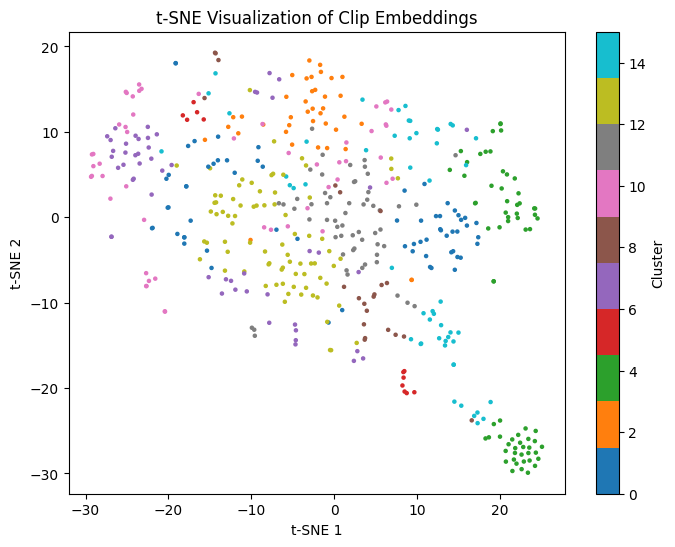

In [19]:
xy_tsne = TSNE(n_components=2, random_state=0, perplexity=30).fit_transform(Xpca)

plt.figure(figsize=(8,6))
plt.scatter(xy_tsne[:,0], xy_tsne[:,1], c=clus, cmap='tab10', s=5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization of Clip Embeddings')
plt.colorbar(label='Cluster')
plt.show()

### 3.3 Interactive 3D PCA

In [29]:
xy = UMAP(n_components=3, n_neighbors=50).fit_transform(Xpca)


C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [39]:
fig = px.scatter_3d(
    x=xy[:, 0], y=xy[:, 1], z=xy[:, 2],
    color=clus,  
    labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'z': 'UMAP 3'},
    title='Interactive 3D UMAP (after PCA) of Embeddings',
    opacity=0.7
)
fig.update_traces(marker=dict(size=3)) 
pio.show(fig)
fig.write_html("Interactive 3D UMAP (after PCA) of Embeddings.html")

### 3.4 NMF

In [56]:
n_components = 8  
nmf = NMF(n_components=n_components, random_state=0)
W = nmf.fit_transform(embeddings)  
H = nmf.components_                 

C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\User\anaconda3\envs\video_embedding\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


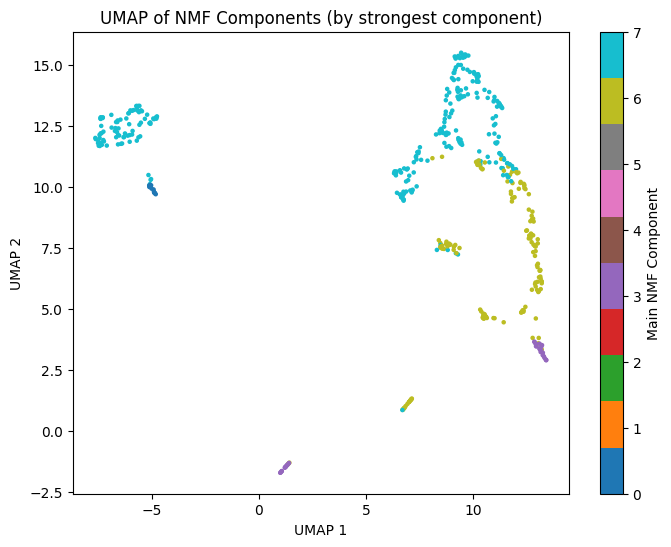

In [57]:
xy_nmf = UMAP(n_components=2, random_state=0).fit_transform(W)

plt.figure(figsize=(8,6))
plt.scatter(xy_nmf[:,0], xy_nmf[:,1], c=W.argmax(axis=1), cmap='tab10', s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of NMF Components (by strongest component)')
plt.colorbar(label='Main NMF Component')
plt.show()